# Deep Reinforcement Learning

Deep Q-Learning or Deep Q-Network (DQN)

In [2]:
! pip install gymnasium
! pip install matplotlib
!apt-get install -y xvfb
!pip install gymnasium[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay
# !pip install https://github.com/PyTorchLightning/pytorch-lightning/archive/refs/heads/release/1.5.x.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 24 not upgraded.
Need to get 7,697 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubu

In [3]:
# Import the necessary modules and packages
from IPython.display import HTML
from base64 import b64encode

# Define a function for displaying videos in Jupyter notebooks
def display_video(episode=0):
    # Read the video file as binary data
    video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
    # Encode the video data in base64 format
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    # Return an HTML object that displays the video in the notebook
    return HTML(f"<video width=600 controls><source src='{video_url}'></video>")


In [4]:
# Define a function for creating a new OpenAI Gym environment
def create_environment(name):
    # Create a new environment object using the specified name
    env = gym.make(name)
    # Set a maximum number of steps per episode
    env = TimeLimit(env, max_episode_steps=400)
    # Record a video of the environment every 100 episodes
    record_interval = 100
    env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % record_interval == 0)
    # Record episode statistics such as reward, length, and time
    env = RecordEpisodeStatistics(env)
    # Return the modified environment object
    return env


In [5]:
# Import the necessary modules and packages
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from collections import namedtuple, deque
from itertools import count

# Check whether CUDA is available and select the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()

# Print the device and number of GPUs to the console
print(device, num_gpus)


cuda:0 1


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/__init__.py:38: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


# LunarLander-v2

In this project, a deep Q-learning algorithm is used to train an agent to play the LunarLander-v2 game from Gymnasium. LunarLander-v2 is a classic control task in which the agent is required to land a spacecraft safely on the moon's surface while controlling its speed and orientation. The game is considered solved when the agent successfully lands the spacecraft.


Install [gym](https://github.com/openai/gym) or 
[gymnasium](https://gymnasium.farama.org/)_ for the environment.


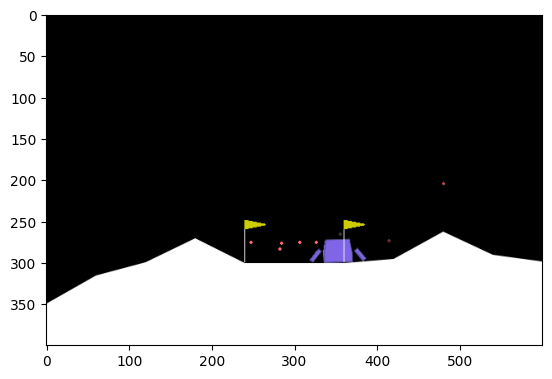

In [6]:
# Import the necessary modules and packages
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

# Create a new environment object using the 'LunarLander-v2' environment from OpenAI Gym
env = create_environment('LunarLander-v2')

# Reset the environment to its initial state
env.reset()

# Test the environment's observation and action spaces
env.observation_space.sample()
env.action_space.sample()
print("action_space_n=", env.action_space.n)

# Take a certain number of steps in the environment and display each frame as an image
num_steps = 100 # number of steps to take
steps_per_frame = 15 # number of steps to take per frame
for i in range(num_steps // steps_per_frame):
    clear_output(wait=True) # clear previous output
    for j in range(steps_per_frame):
        action = env.action_space.sample() # sample an action from the action space
        observation, reward, done, info = env.step(action) # take a step in the environment using the sampled action
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()
    time.sleep(0.01) # pause for a short time between frames


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("LunarLander-v2")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [9]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # a copy of q-function(dnns) Q old -

# Replay Memory
# We'll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, 
# allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. 
# It has been shown that this greatly stabilizes and improves the DQN training procedure.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


# Store episode durations and rewards for plotting
episode_durations = []
episode_rewards = []
reward_episode = []
duration_episode = []

# Plot episode rewards and durations during training
def plot_durations(reward_episode, duration_episode, show_result=False):
    plt.figure(1, figsize=[25, 8])
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.clf()
    plt.subplot(121)
    plt.title('Episode reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(reward_episode, 'b')
    plt.subplot(122)
    plt.title('Episode duration')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_episode, 'r')
    plt.pause(0.001)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # current Q

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch # r + dis * Q(s')

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) # different current q -  new q

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:

    
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [12]:
import math
import os
import glob
import io
import base64
import pylab as pl
import pandas as pd
from IPython import display as ipythondisplay
%matplotlib inline
from IPython.display import clear_output

In [13]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('/content/video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = RecordVideo(env, '/content/video',  episode_trigger = lambda episode_number: True)
  return env

env = wrap_env(env)

In [14]:
from pyvirtualdisplay import Display
display2 = Display(visible=0, size=(1400, 900))
display2.start()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state) # trade-off between exploration and exploitation. action = env.action_space.sample() pure exploration
        observation, reward, terminated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
          # Append episode reward and duration to their respective lists
          durations_t = torch.tensor(episode_durations, dtype=torch.float)
          durations_t.numpy()
          episode_durations.append(t + 1)

          rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
          rewards_t.numpy()
          episode_rewards.append(reward.item())

          show_video()
          print(num_episodes)

          plot_durations(rewards_t.numpy(), durations_t.numpy())

          break
    if i_episode % 25 == 0:
      print(i_episode, reward)

    if i_episode % 50 == 0:
        for v in os.listdir('/content/video'):
            os.remove('/content/video/' + v)
        show_video()

print('Complete after ', num_episodes, " episodes")
print(episode_rewards)
plot_durations(rewards_t.numpy(), durations_t.numpy(), show_result=True)
plt.ioff()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
